In [40]:
pip install attention


In [41]:
import pandas as pd
import numpy as np
from attention import Attention
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Bidirectional, Input
from tensorflow.keras.callbacks import EarlyStopping, ModelCheckpoint

In [42]:
data = pd.read_csv('/content/Datasets-kathmandu.csv')

In [43]:
data = data.drop(columns = ['ds'])

In [44]:
import pandas as pd

# Assuming 'data' is your DataFrame containing the dataset
num_data_points = len(data)

# Create a date range from '2016-01-01' to the number of df points in 'df'
date_range = pd.date_range(start='2016-01-01', periods=num_data_points, freq='D')

# Now 'date_range' contains the datetime values starting from '2016-01-01' and ending at the number of df points in 'df'
data = pd.concat([data, pd.DataFrame({'ds': date_range})], axis=1)


In [45]:
scaler = MinMaxScaler(feature_range=(0,1))
scaled_data = scaler.fit_transform(data['y'].values.reshape(-1,1))
unscaled_data = scaler.inverse_transform(scaled_data)
scaled_data

array([[0.28262424],
       [0.2646923 ],
       [0.29196114],
       ...,
       [0.78877635],
       [0.76899347],
       [0.78141847]])

In [46]:
data['ds'] = pd.to_datetime(data['ds'])

# Define the split dates
train_end_date = '2021-08-01'
test_end_date = '2023-02-28'

# Split the data based on the defined dates
train_data = scaled_data[data['ds'] <= train_end_date]
test_data = scaled_data[(data['ds'] > train_end_date) & (data['ds'] <= test_end_date)]
forecast_data = scaled_data[data['ds'] > test_end_date]

In [65]:
def create_sequences(data, seq_length):
    X = []
    y = []
    for i in range(len(data) - seq_length):
        X.append(data[i:i+seq_length])
        y.append(data[i+seq_length])
    return np.array(X), np.array(y)

sequence_length = 20
X_train, y_train = create_sequences(train_data, sequence_length)
X_test, y_test = create_sequences(test_data, sequence_length)
X_forecast, y_forecast = create_sequences(forecast_data, sequence_length)

# check the shape of the data
print(X_train.shape)
print(y_train.shape)
print(X_test.shape)
print(y_test.shape)

(2020, 20, 1)
(2020, 1)
(556, 20, 1)
(556, 1)


In [66]:
data['ds'] = pd.to_datetime(data['ds'])

test_end_date = '2023-02-28'

# Split the data based on the defined dates
data = data[data['ds'] <= test_end_date]
data

,y,ds
0,191.231263,2016-01-01
1,183.040896,2016-01-02
2,195.495871,2016-01-03
3,193.733857,2016-01-04
4,193.534451,2016-01-05
...,...,...
2611,340.230000,2023-02-24
2612,375.120000,2023-02-25
2613,369.380000,2023-02-26
2614,369.170000,2023-02-27


In [67]:
from keras.layers import Input, GRU, Dense, Attention
from keras.models import Model

sequence_length = 20  # Specify your sequence length here

inputs = Input(shape=(sequence_length, 1))
gru_out = GRU(128, return_sequences=True)(inputs)  # GRU layer

# Define query and value inputs for the Attention layer
query = gru_out  # Query is the output of the GRU layer
value = gru_out  # Value is also the output of the GRU layer

attention_out = Attention(32)([query, value])  # Attention layer with query and value inputs
outputs = Dense(1)(attention_out)

model = Model(inputs=inputs, outputs=outputs)
model.compile(optimizer="adam", loss="mean_squared_error")


In [68]:
early_stopping = EarlyStopping(monitor='val_loss', patience=10, verbose=1, restore_best_weights=True)
model_checkpoint = ModelCheckpoint('best_model.h5', monitor='val_loss', save_best_only=True, verbose=1)

# Train the model with validation
history = model.fit(X_train, y_train, epochs=100, batch_size=80 , validation_data=(X_test, y_test),
                    callbacks=[early_stopping, model_checkpoint])

Epoch 1/100
25/26 [===========================>..] - ETA: 0s - loss: 0.0394
Epoch 1: val_loss improved from inf to 0.03431, saving model to best_model.h5
26/26 [==============================] - 4s 76ms/step - loss: 0.0390 - val_loss: 0.0343
Epoch 2/100
 5/26 [====>.........................] - ETA: 0s - loss: 0.0080

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(


24/26 [==========================>...] - ETA: 0s - loss: 0.0057
Epoch 2: val_loss improved from 0.03431 to 0.00698, saving model to best_model.h5
26/26 [==============================] - 1s 32ms/step - loss: 0.0056 - val_loss: 0.0070
Epoch 3/100
24/26 [==========================>...] - ETA: 0s - loss: 0.0023
Epoch 3: val_loss improved from 0.00698 to 0.00422, saving model to best_model.h5
26/26 [==============================] - 1s 33ms/step - loss: 0.0023 - val_loss: 0.0042
Epoch 4/100
25/26 [===========================>..] - ETA: 0s - loss: 0.0016
Epoch 4: val_loss did not improve from 0.00422
26/26 [==============================] - 1s 33ms/step - loss: 0.0016 - val_loss: 0.0044
Epoch 5/100
25/26 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 5: val_loss did not improve from 0.00422
26/26 [==============================] - 1s 33ms/step - loss: 0.0015 - val_loss: 0.0044
Epoch 6/100
25/26 [===========================>..] - ETA: 0s - loss: 0.0015
Epoch 6: val_loss did 

In [69]:
# Evaluate the model
train_loss = model.evaluate(X_train, y_train, verbose=0)
test_loss = model.evaluate(X_test, y_test, verbose=0)
print("Train Loss:", train_loss)
print("Test Loss:", test_loss)

Train Loss: 0.0005882647819817066
Test Loss: 0.002513471059501171


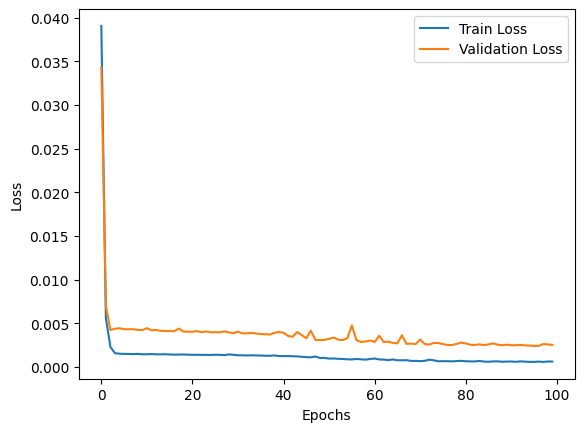

In [70]:
plt.plot(history.history['loss'], label='Train Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

18/18 [==============================] - 0s 6ms/step


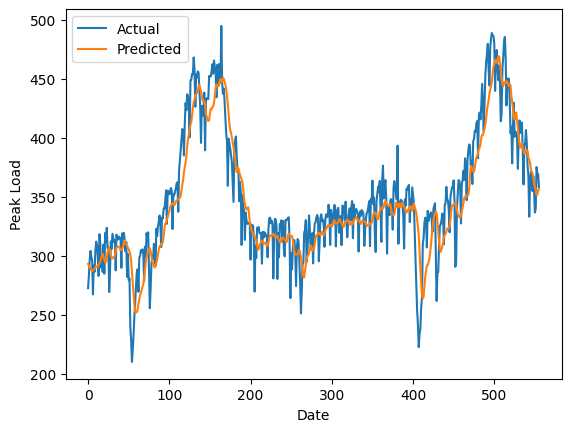

In [71]:
# Load the best model
best_model = Model(inputs=inputs, outputs=outputs)
best_model.load_weights('best_model.h5')

# Test the best model on unseen data
predicted = best_model.predict(X_test)
predicted = [elem[0] for elem in predicted]
predicted = scaler.inverse_transform(predicted)
y_test = scaler.inverse_transform(y_test)

# Plot the predicted results and actual values
plt.plot(y_test, label='Actual')
plt.plot(predicted, label='Predicted')
plt.xlabel('Date')
plt.ylabel('Peak Load')
plt.legend()
plt.show()

Text(0.5, 1.0, 'Data vs Time')

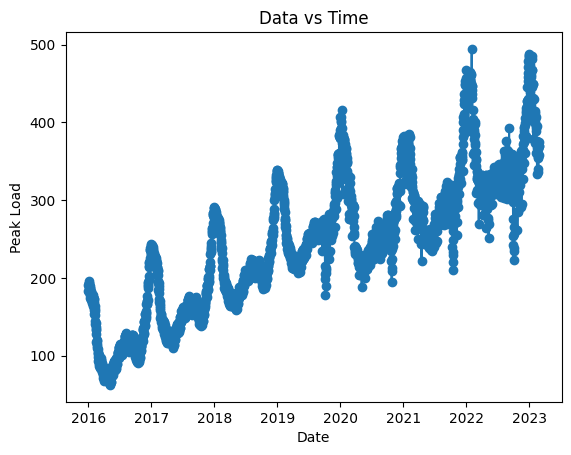

In [72]:
plt.plot(data['ds'], data['y'], marker='o', linestyle='-')

# Set labels and title
plt.xlabel('Date')
plt.ylabel('Peak Load')
plt.title('Data vs Time')

In [73]:
data.tail()

,y,ds
2611,340.23,2023-02-24
2612,375.12,2023-02-25
2613,369.38,2023-02-26
2614,369.17,2023-02-27
2615,358.01,2023-02-28


In [74]:
from sklearn.metrics import mean_absolute_error, r2_score
import numpy as np

# Making predictions
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# print("Y train",y_train)
# print("Y test",y_test)
# print("Y train pred",y_train_pred)
# print("Y test pred",y_test_pred)
# y_test = scaler.transform(y_test)
y_test_pred = [elem[0] for elem in y_test_pred]
y_test_pred = scaler.inverse_transform(y_test_pred)


# # print(y_test)
# Calculate MAE


18/18 [==============================] - 0s 6ms/step


In [75]:

print(y_test.shape)

(556, 1)


In [76]:
y_test_pred = y_test_pred[:, 0].reshape(-1, 1)
y_train_pred = y_train_pred[:, 0].reshape(-1, 1)
y_test_pred.shape

(556, 1)

In [77]:
train_mae = mean_absolute_error(y_train, y_train_pred)
test_mae = mean_absolute_error(y_test, y_test_pred)

# Calculate MAPE
def mean_absolute_percentage_error(y_true, y_pred):
    return np.mean(np.abs((y_true - y_pred) / y_true)) * 100

train_mape = mean_absolute_percentage_error(y_train, y_train_pred)
test_mape = mean_absolute_percentage_error(y_test, y_test_pred)

# Calculate R^2
train_r2 = r2_score(y_train, y_train_pred)
test_r2 = r2_score(y_test, y_test_pred)


<ipython-input-77-be8b0df5a208>:6: RuntimeWarning: divide by zero encountered in divide
  return np.mean(np.abs((y_true - y_pred) / y_true)) * 100


In [78]:
print("Test MAE:", test_mae)
print("Test MAPE:", test_mape)
print("Test R^2:", test_r2)

Test MAE: 18.97319996403603
Test MAPE: 5.614746843752337
Test R^2: 0.8068256613907835


In [79]:
y_forecast = best_model.predict(X_forecast)
y_forecast = y_test_pred = [elem[0] for elem in y_forecast]

23/23 [==============================] - 0s 6ms/step


In [80]:
y_forecast = scaler.inverse_transform(y_forecast)
y_forecast = y_forecast[:, 0].reshape(-1, 1)

In [81]:
y_forecast.shape


(712, 1)

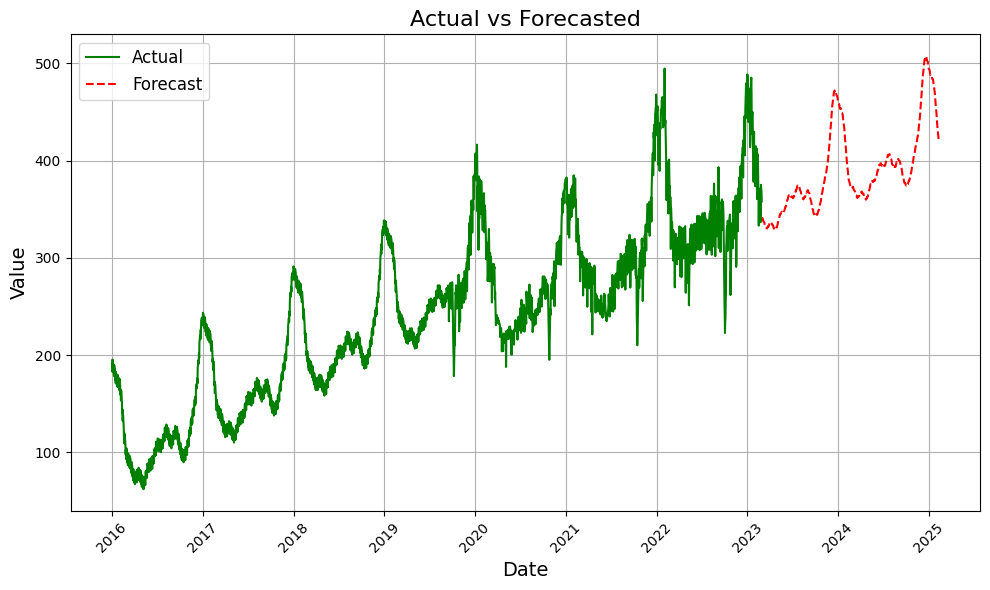

In [82]:
import matplotlib.pyplot as plt
import pandas as pd

y_forecast = y_forecast.flatten()

dates = pd.date_range(start='2023-03-01', periods=len(y_forecast), freq='D')

forecast_df = pd.DataFrame({'ds': dates, 'y': y_forecast})

plt.figure(figsize=(10, 6))

plt.plot(data['ds'], data['y'], label='Actual', color='green')

plt.plot(forecast_df['ds'], forecast_df['y'], label='Forecast', linestyle='--', color='red')

plt.xlabel('Date', fontsize=14)
plt.ylabel('Value', fontsize=14)
plt.title('Actual vs Forecasted', fontsize=16)

plt.grid(True)

plt.legend(fontsize=12)

# Rotate x-axis labels for better readability
plt.xticks(rotation=45)

# Show plot
plt.tight_layout()  # Adjust layout
plt.show()

